In [1]:
import jax
import jax.numpy as jnp
import flax.linen as nn
import numpy as np
import optax
from flax.linen.initializers import constant, orthogonal
from typing import Sequence, NamedTuple, Any
from flax.training.train_state import TrainState
import distrax
import gymnax
from gymnax.wrappers.purerl import LogWrapper, FlattenObservationWrapper
import time
from tqdm import tqdm

import sys
sys.path.insert(0, '..')  # adds the root directory to the path

from policy_distillation.behaviour_clone import BCAgent, Transition, make_train
import matplotlib.pyplot as plt


# Meta-learning the Dataset

## Setup

In [2]:
from evosax import OpenES, ParameterReshaper

def get_configs_params(
                fail_prob = 0.01, 
                datapoints_per_action = 1, 
                num_envs = 16, 
                num_epochs = 40, 
                activation = "relu", 
                greedy_act = False,
                n_generations = 100,
                env_name = "FourRooms-misc"
                ):

    

    config = {
        "LR": 5e-2,  # 5e-3      # 2.5e-2 to 5e-2 brings BC loss to ~0 for UPDATE_EPOCHS=10 and up to 100 states/action
        "NUM_ENVS": num_envs,   #8 # Num eval envs
        "NUM_STEPS": 512,   #128 # Max num eval steps per env
        "UPDATE_EPOCHS": num_epochs,  # Num BC gradient steps
        "MAX_GRAD_NORM": 0.5,
        "ACTIVATION": activation,
        "WIDTH" : 64,
        "ENV_NAME": env_name,
        "ANNEAL_LR": True,
        "GREEDY_ACT": greedy_act,  # Whether to use greedy act in env or sample
        "ENV_PARAMS" : {
            "fail_prob" : fail_prob
        }
    }

    env, env_params = gymnax.make(env_name, use_visual_obs=False)
    env_params = env_params.replace(**config["ENV_PARAMS"])
    env = FlattenObservationWrapper(env)
    env = LogWrapper(env)

    n_actions = env.action_space(env_params).n

    es_config = {
        "popsize": 500,  # Num of candidates
        "dataset_size": n_actions * datapoints_per_action, #10 #20000,  # Num of (s,a) pairs (split evenly across actions)
        "rollouts_per_candidate": 16,  #32 Num of BC policies trained per candidate
        "n_generations": n_generations,
        "log_interval": 20,
    }

    params = jnp.zeros(
        (es_config["dataset_size"], *env.observation_space(env_params).shape)
    )
    param_reshaper = ParameterReshaper(params)
    
    return config, es_config, n_actions, params, param_reshaper

## Initialize Strategy

In [3]:
# Initialize OpenES Strategy
def get_action_labels(d_size, n_actions):
        action_labels = jnp.array([i % n_actions for i in range(d_size)])
        action_labels = action_labels.sort()
        return action_labels

def initialize_es(config, es_config, param_reshaper, n_actions):

    rng = jax.random.PRNGKey(0)
    rng, rng_init = jax.random.split(rng)

    strategy = OpenES(
        popsize=es_config["popsize"],
        num_dims=param_reshaper.total_params,
        opt_name="adam",
        maximize=True,
    )

    # Replace state mean with real observations
    # state = state.replace(mean = sampled_data)

    es_params = strategy.default_params
    # es_params = es_params.replace(init_max=10.0)
    state = strategy.initialize(rng_init, es_params)

    # Set up vectorized fitness function
    train_fn = make_train(config)
    action_labels = get_action_labels(es_config["dataset_size"], n_actions)

    def single_seed_BC(rng_input, dataset):
        out = train_fn(dataset, action_labels, rng_input)
        return out  # ["metrics"]['returned_episode_returns'].mean()

    multi_seed_BC = jax.vmap(single_seed_BC, in_axes=(0, None))  # Vectorize over seeds
    train_and_eval = jax.jit(jax.vmap(multi_seed_BC, in_axes=(None, 0)))  # Vectorize over datasets

    if len(jax.devices()) > 1:
        train_and_eval = jax.pmap(train_and_eval, in_axes=(None, 0))
        
    return train_and_eval, strategy, state, es_params, rng

## Run OpenES loop

In [4]:
def get_rollout_returns(best_idx, returns, dones, P, num_envs):
    if len(jax.devices()) > 1:
        best_idx = (best_idx // (P//2), best_idx % (P//2))
    else:
        best_idx = (best_idx % (P//2))

    best_ret = returns[best_idx]
    best_dones = dones[best_idx]

    best_mean_ret  = (best_ret*best_dones).sum(axis=(1,2)) / num_envs
    return best_mean_ret
    

def run_es(config, train_and_eval, es_config, strategy, state, param_reshaper, es_params, rng):
    start = time.time()
    lap_start = start
    fitness_over_gen = []
    max_fitness_over_gen = []
    best_rollouts_returns = []
    for gen in range(es_config["n_generations"]):
        # Gen new dataset
        rng, rng_ask, rng_inner = jax.random.split(rng, 3)
        datasets, state = jax.jit(strategy.ask)(rng_ask, state, es_params)
        # Eval fitness
        batch_rng = jax.random.split(rng_inner, es_config["rollouts_per_candidate"])
        # Preemptively overwrite to reduce memory load
        out = None
        returns = None
        dones = None
        fitness = None
        shaped_datasets = None

        with jax.disable_jit(False):
            shaped_datasets = param_reshaper.reshape(datasets)
            out = train_and_eval(batch_rng, shaped_datasets)

            returns = out["metrics"]["returned_episode_returns"]  # dim=(popsize, rollouts, num_steps, num_envs)
            dones = out["metrics"]["returned_episode"]  # same dim, True for last steps, False otherwise

            # Fitness is cumulative return over 512 steps, averaged over rollouts and envs
            # This is necessary since FourRooms has no penalty for finding the goal in many steps
            fitness = (returns * dones).sum(axis=(-1, -2, -3)) / (es_config["rollouts_per_candidate"] * config["NUM_ENVS"]) #/ dones.sum(axis=(-1, -2, -3))  # fitness, dim = (popsize)
            fitness = fitness.flatten()    # Necessary if pmap-ing to 2+ devices

        # Update ES strategy with fitness info
        state = jax.jit(strategy.tell)(datasets, fitness, state, es_params)
        fitness_over_gen.append(fitness.mean())
        max_fitness_over_gen.append(fitness.max())
        
        rollout_returns = get_rollout_returns(fitness.argmax(), returns, dones, es_config["popsize"], config["NUM_ENVS"])
        best_rollouts_returns.append(rollout_returns)
        
        assert jnp.absolute(rollout_returns.mean() - fitness.max()) < 1e-3

        if gen % es_config["log_interval"] == 0 or gen == 0:
            lap_end = time.time()
            if len(jax.devices()) > 1:
                bc_loss = out["metrics"]["bc_loss"][:,:,:,-1]
                bc_acc = out["metrics"]["bc_accuracy"][:,:,:,-1]
            else:
                bc_loss = out["metrics"]["bc_loss"][:,:,-1]
                bc_acc = out["metrics"]["bc_accuracy"][:,:,-1]

            print(
                f"Gen: {gen}, Fitness: {fitness.mean():.2f} +/- {fitness.std():.2f}, "
                + f"Best: {state.best_fitness:.2f}, BC loss: {bc_loss.mean():.2f} +/- {bc_loss.std():.2f}, "
                + f"BC acc: {bc_acc.mean():.2f} +/- {bc_acc.std():.2f}, Lap time: {lap_end-lap_start:.1f}s"
            )
            lap_start = lap_end
    print(f"Total time: {(lap_end-start)/60:.1f}min")
    
    log = {
        "fitness_over_gen" : jnp.array(fitness_over_gen),
        "max_fitness_over_gen" : jnp.array(max_fitness_over_gen),
        "best_rollouts_returns" : jnp.array(best_rollouts_returns)
    }

    return out, fitness, log, state

In [5]:
def plot_fitness(log, config, es_config):
    fitness_over_gen = log["fitness_over_gen"]
    max_fitness_over_gen = log["max_fitness_over_gen"]
    brr = log["best_rollouts_returns"]

    y = fitness_over_gen
    plt.plot(fitness_over_gen, label="Mean fitness")
    y = max_fitness_over_gen
    plt.plot(np.arange(brr.shape[0]), max_fitness_over_gen, color="green", label="Max fitness (std)")
    plt.fill_between(np.arange(brr.shape[0]), max_fitness_over_gen-brr.std(1), max_fitness_over_gen+brr.std(1), 
                     color="green", alpha=0.2)
    plt.plot(brr.min(1), ls="--", color="green", label="max/min returns")
    plt.plot(brr.max(1), ls="--", color="green")

    act = "greedy" if config["GREEDY_ACT"] else "softmax"
    plt.title(f"{config['ENV_NAME']}, p={config['ENV_PARAMS']['fail_prob']}, {act} policy, |D|={es_config['dataset_size']}")
    plt.ylabel("Fitness (Return)")
    plt.xlabel("Meta-learner Generations")
    plt.legend()
    plt.show()

In [ ]:
config, es_config, n_actions, params, param_reshaper = get_configs_params(
    fail_prob = 0.1, 
    datapoints_per_action = 2, 
    greedy_act = False,
    n_generations = 30
)

train_and_eval, strategy, state, es_params, rng = initialize_es(config, es_config, param_reshaper, n_actions)

out, fitness, log, state = run_es(config, train_and_eval, es_config, strategy, state, param_reshaper, es_params, rng)




DATASET SIZE : n_actions x  2

ParameterReshaper: 2 devices detected. Please make sure that the ES population size divides evenly across the number of devices to pmap/parallelize over.
ParameterReshaper: 32 parameters detected for optimization.
Gen: 0, Fitness: 0.00 +/- 0.00, Best: 0.00, BC loss: 0.14 +/- 0.17, BC acc: 0.95 +/- 0.09, Lap time: 4.6s
Gen: 20, Fitness: 1.48 +/- 1.97, Best: 15.75, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 26.2s
Gen: 40, Fitness: 1.50 +/- 1.80, Best: 15.75, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 26.1s
Gen: 60, Fitness: 1.88 +/- 1.99, Best: 15.75, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 26.1s
Gen: 80, Fitness: 2.51 +/- 2.27, Best: 15.75, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 26.1s
Gen: 100, Fitness: 1.42 +/- 1.78, Best: 15.75, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 26.1s
Gen: 120, Fitness: 2.46 +/- 2.13, Best: 15.75, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time

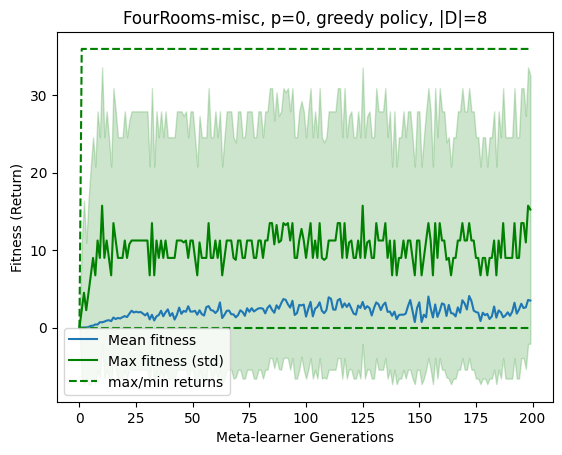

ParameterReshaper: 2 devices detected. Please make sure that the ES population size divides evenly across the number of devices to pmap/parallelize over.
ParameterReshaper: 32 parameters detected for optimization.


/private/home/alupu/.conda/envs/exp-env/lib/python3.9/site-packages/jax/_src/numpy/array_methods.py:795: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)


Gen: 0, Fitness: 0.00 +/- 0.00, Best: 0.00, BC loss: 0.14 +/- 0.17, BC acc: 0.95 +/- 0.09, Lap time: 4.7s
Gen: 20, Fitness: 1.02 +/- 1.54, Best: 10.75, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 26.9s
Gen: 40, Fitness: 1.89 +/- 2.11, Best: 13.50, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 26.9s
Gen: 60, Fitness: 1.75 +/- 1.84, Best: 13.50, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 26.8s
Gen: 80, Fitness: 1.89 +/- 1.95, Best: 15.14, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 26.7s
Gen: 100, Fitness: 2.56 +/- 2.24, Best: 15.14, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 26.9s
Gen: 120, Fitness: 2.53 +/- 2.19, Best: 17.40, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 26.0s
Gen: 140, Fitness: 2.25 +/- 2.18, Best: 17.40, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 25.8s
Gen: 160, Fitness: 2.67 +/- 2.30, Best: 17.40, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 26.0s
Gen: 180, Fitness:

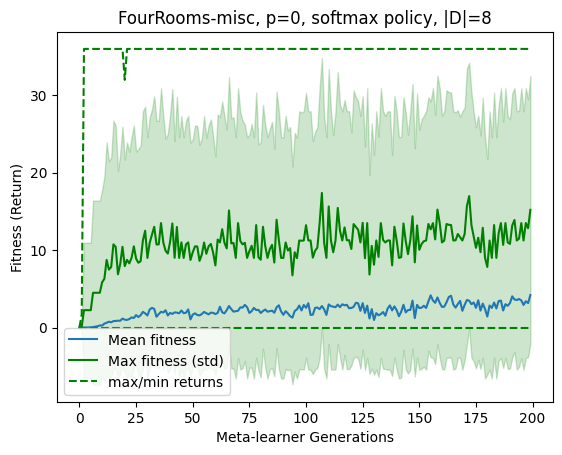

ParameterReshaper: 2 devices detected. Please make sure that the ES population size divides evenly across the number of devices to pmap/parallelize over.
ParameterReshaper: 32 parameters detected for optimization.
Gen: 0, Fitness: 0.00 +/- 0.03, Best: 0.39, BC loss: 0.14 +/- 0.17, BC acc: 0.95 +/- 0.09, Lap time: 4.3s
Gen: 20, Fitness: 0.42 +/- 0.10, Best: 0.90, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 26.4s
Gen: 40, Fitness: 0.53 +/- 0.08, Best: 0.98, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 25.8s
Gen: 60, Fitness: 0.56 +/- 0.08, Best: 0.98, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 26.5s
Gen: 80, Fitness: 0.57 +/- 0.10, Best: 0.98, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 25.9s
Gen: 100, Fitness: 0.63 +/- 0.09, Best: 1.09, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 25.8s
Gen: 120, Fitness: 0.56 +/- 0.08, Best: 1.09, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 25.7s
Gen: 140, Fitness: 0.56 +/- 0.

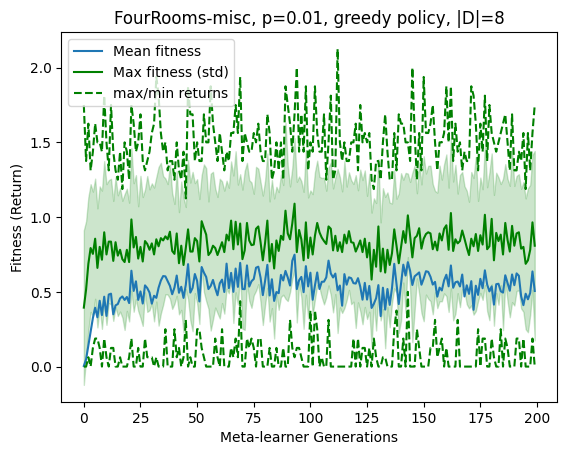

ParameterReshaper: 2 devices detected. Please make sure that the ES population size divides evenly across the number of devices to pmap/parallelize over.
ParameterReshaper: 32 parameters detected for optimization.


/private/home/alupu/.conda/envs/exp-env/lib/python3.9/site-packages/jax/_src/numpy/array_methods.py:795: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)


Gen: 0, Fitness: 0.00 +/- 0.03, Best: 0.39, BC loss: 0.14 +/- 0.17, BC acc: 0.95 +/- 0.09, Lap time: 4.7s
Gen: 20, Fitness: 0.36 +/- 0.12, Best: 0.79, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 26.0s
Gen: 40, Fitness: 0.30 +/- 0.09, Best: 0.84, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 26.1s
Gen: 60, Fitness: 0.35 +/- 0.10, Best: 0.95, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 26.3s
Gen: 80, Fitness: 0.54 +/- 0.08, Best: 0.97, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 26.2s
Gen: 100, Fitness: 0.63 +/- 0.07, Best: 1.04, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 26.2s
Gen: 120, Fitness: 0.58 +/- 0.08, Best: 1.04, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 26.1s
Gen: 140, Fitness: 0.60 +/- 0.11, Best: 1.04, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 26.2s
Gen: 160, Fitness: 0.73 +/- 0.09, Best: 1.04, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 26.2s
Gen: 180, Fitness: 0.61 +/

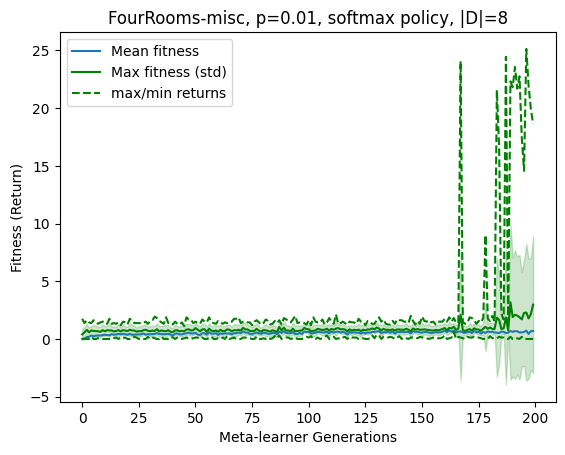

ParameterReshaper: 2 devices detected. Please make sure that the ES population size divides evenly across the number of devices to pmap/parallelize over.
ParameterReshaper: 32 parameters detected for optimization.
Gen: 0, Fitness: 0.04 +/- 0.24, Best: 2.91, BC loss: 0.14 +/- 0.17, BC acc: 0.95 +/- 0.09, Lap time: 4.5s
Gen: 20, Fitness: 3.25 +/- 0.99, Best: 5.27, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 26.0s
Gen: 40, Fitness: 3.98 +/- 0.37, Best: 5.34, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 25.8s
Gen: 60, Fitness: 4.27 +/- 0.57, Best: 5.59, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 25.7s
Gen: 80, Fitness: 4.09 +/- 0.31, Best: 5.59, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 25.7s
Gen: 100, Fitness: 4.67 +/- 0.30, Best: 5.69, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 25.7s
Gen: 120, Fitness: 4.26 +/- 0.27, Best: 5.78, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 25.8s
Gen: 140, Fitness: 4.73 +/- 0.

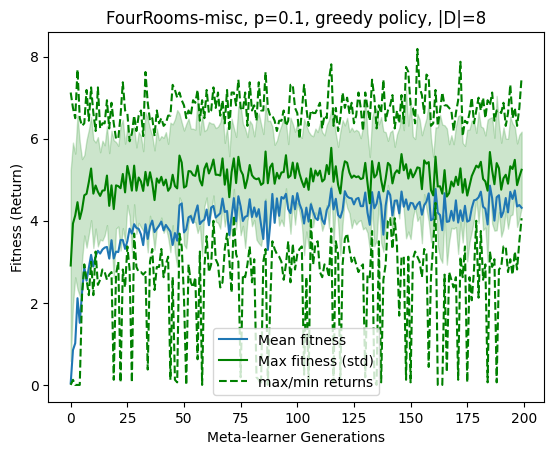

ParameterReshaper: 2 devices detected. Please make sure that the ES population size divides evenly across the number of devices to pmap/parallelize over.
ParameterReshaper: 32 parameters detected for optimization.


/private/home/alupu/.conda/envs/exp-env/lib/python3.9/site-packages/jax/_src/numpy/array_methods.py:795: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)


Gen: 0, Fitness: 0.04 +/- 0.24, Best: 2.89, BC loss: 0.14 +/- 0.17, BC acc: 0.95 +/- 0.09, Lap time: 4.8s
Gen: 20, Fitness: 3.39 +/- 0.38, Best: 5.32, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 26.9s
Gen: 40, Fitness: 3.81 +/- 0.39, Best: 5.36, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 26.7s
Gen: 60, Fitness: 4.52 +/- 0.44, Best: 5.66, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 26.7s
Gen: 80, Fitness: 4.28 +/- 0.65, Best: 5.79, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 26.7s
Gen: 100, Fitness: 4.30 +/- 0.40, Best: 5.79, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 26.7s
Gen: 120, Fitness: 4.82 +/- 0.62, Best: 6.02, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 26.7s
Gen: 140, Fitness: 4.60 +/- 0.33, Best: 6.02, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 26.7s
Gen: 160, Fitness: 4.95 +/- 0.31, Best: 6.02, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 26.8s
Gen: 180, Fitness: 4.88 +/

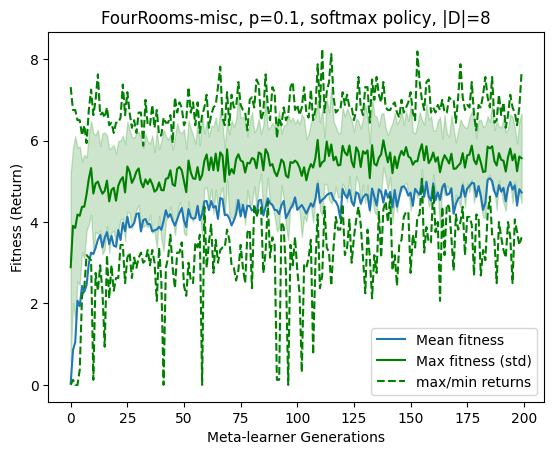

ParameterReshaper: 2 devices detected. Please make sure that the ES population size divides evenly across the number of devices to pmap/parallelize over.
ParameterReshaper: 32 parameters detected for optimization.
Gen: 0, Fitness: 0.08 +/- 0.37, Best: 4.53, BC loss: 0.14 +/- 0.17, BC acc: 0.95 +/- 0.09, Lap time: 4.6s
Gen: 20, Fitness: 5.44 +/- 0.55, Best: 6.99, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 25.4s
Gen: 40, Fitness: 6.01 +/- 0.58, Best: 7.42, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 25.4s
Gen: 60, Fitness: 5.86 +/- 0.55, Best: 7.64, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 25.4s
Gen: 80, Fitness: 6.09 +/- 0.37, Best: 7.64, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 25.3s
Gen: 100, Fitness: 5.85 +/- 0.24, Best: 7.64, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 25.2s
Gen: 120, Fitness: 6.59 +/- 0.25, Best: 7.64, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 25.3s
Gen: 140, Fitness: 6.44 +/- 0.

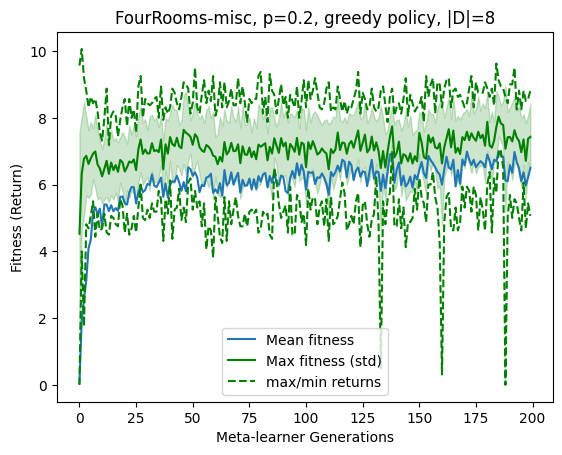

ParameterReshaper: 2 devices detected. Please make sure that the ES population size divides evenly across the number of devices to pmap/parallelize over.
ParameterReshaper: 32 parameters detected for optimization.


/private/home/alupu/.conda/envs/exp-env/lib/python3.9/site-packages/jax/_src/numpy/array_methods.py:795: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)


Gen: 0, Fitness: 0.08 +/- 0.37, Best: 4.48, BC loss: 0.14 +/- 0.17, BC acc: 0.95 +/- 0.09, Lap time: 4.8s
Gen: 20, Fitness: 5.12 +/- 0.61, Best: 7.14, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 26.7s
Gen: 40, Fitness: 5.06 +/- 0.79, Best: 7.14, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 26.6s
Gen: 60, Fitness: 5.66 +/- 0.62, Best: 7.14, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 25.9s
Gen: 80, Fitness: 5.66 +/- 0.75, Best: 7.61, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 25.8s
Gen: 100, Fitness: 5.93 +/- 0.43, Best: 7.73, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 25.9s
Gen: 120, Fitness: 6.15 +/- 0.47, Best: 7.73, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 25.9s
Gen: 140, Fitness: 6.16 +/- 0.73, Best: 7.73, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 25.9s
Gen: 160, Fitness: 6.44 +/- 0.52, Best: 7.73, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 25.9s
Gen: 180, Fitness: 6.47 +/

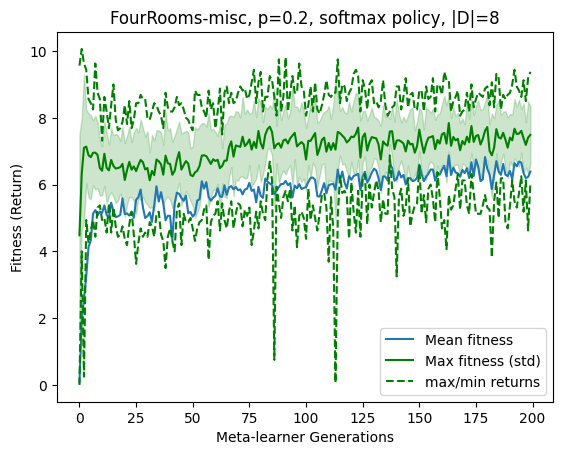


DATASET SIZE : n_actions x  4

ParameterReshaper: 2 devices detected. Please make sure that the ES population size divides evenly across the number of devices to pmap/parallelize over.
ParameterReshaper: 64 parameters detected for optimization.
Gen: 0, Fitness: 0.00 +/- 0.00, Best: 0.00, BC loss: 0.51 +/- 0.19, BC acc: 0.78 +/- 0.11, Lap time: 4.7s
Gen: 20, Fitness: 0.00 +/- 0.10, Best: 2.25, BC loss: 0.52 +/- 0.19, BC acc: 0.78 +/- 0.12, Lap time: 25.7s
Gen: 40, Fitness: 0.95 +/- 1.72, Best: 13.50, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 25.6s
Gen: 60, Fitness: 2.06 +/- 2.30, Best: 15.75, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 25.9s
Gen: 80, Fitness: 3.75 +/- 2.83, Best: 15.75, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 25.6s
Gen: 100, Fitness: 5.03 +/- 3.29, Best: 18.00, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 25.9s
Gen: 120, Fitness: 5.19 +/- 3.88, Best: 22.50, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time:

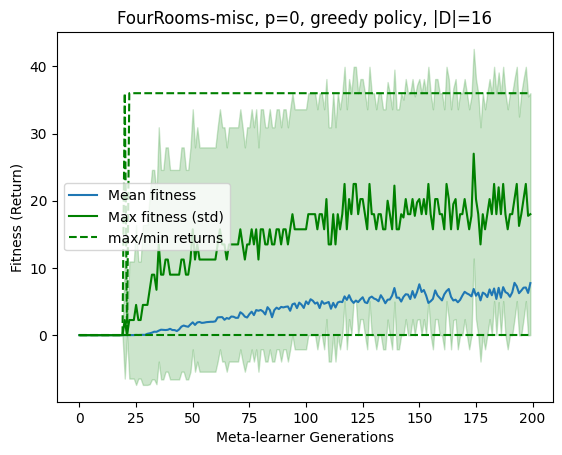

ParameterReshaper: 2 devices detected. Please make sure that the ES population size divides evenly across the number of devices to pmap/parallelize over.
ParameterReshaper: 64 parameters detected for optimization.


/private/home/alupu/.conda/envs/exp-env/lib/python3.9/site-packages/jax/_src/numpy/array_methods.py:795: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)


Gen: 0, Fitness: 0.00 +/- 0.00, Best: 0.00, BC loss: 0.51 +/- 0.19, BC acc: 0.78 +/- 0.11, Lap time: 4.5s
Gen: 20, Fitness: 0.02 +/- 0.32, Best: 6.24, BC loss: 0.07 +/- 0.08, BC acc: 0.98 +/- 0.04, Lap time: 26.3s
Gen: 40, Fitness: 0.73 +/- 1.45, Best: 11.02, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 26.2s
Gen: 60, Fitness: 2.05 +/- 2.47, Best: 13.36, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 26.2s
Gen: 80, Fitness: 3.55 +/- 2.90, Best: 15.75, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 26.1s
Gen: 100, Fitness: 5.15 +/- 3.61, Best: 20.25, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 26.1s
Gen: 120, Fitness: 7.07 +/- 4.09, Best: 22.50, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 26.2s
Gen: 140, Fitness: 8.32 +/- 4.36, Best: 27.00, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 26.0s
Gen: 160, Fitness: 12.03 +/- 4.85, Best: 29.53, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 26.2s
Gen: 180, Fitness:

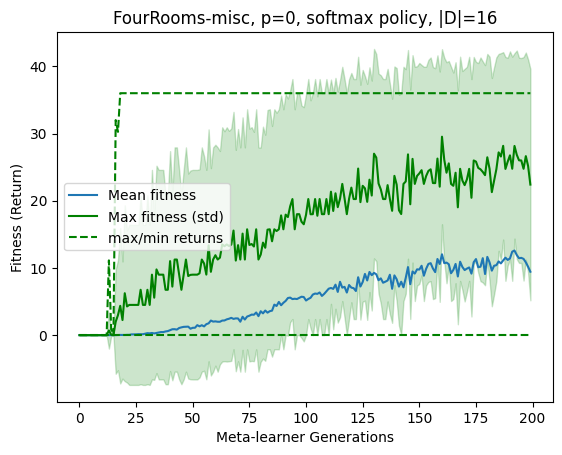

ParameterReshaper: 2 devices detected. Please make sure that the ES population size divides evenly across the number of devices to pmap/parallelize over.
ParameterReshaper: 64 parameters detected for optimization.
Gen: 0, Fitness: 0.00 +/- 0.01, Best: 0.06, BC loss: 0.51 +/- 0.19, BC acc: 0.78 +/- 0.11, Lap time: 4.6s
Gen: 20, Fitness: 0.44 +/- 0.10, Best: 0.92, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 25.7s
Gen: 40, Fitness: 0.50 +/- 0.16, Best: 0.98, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 26.1s
Gen: 60, Fitness: 0.65 +/- 0.11, Best: 1.02, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 26.0s
Gen: 80, Fitness: 0.72 +/- 0.11, Best: 1.12, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 25.9s
Gen: 100, Fitness: 0.71 +/- 0.11, Best: 1.18, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 26.1s
Gen: 120, Fitness: 0.70 +/- 0.09, Best: 1.18, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 26.2s
Gen: 140, Fitness: 0.71 +/- 0.

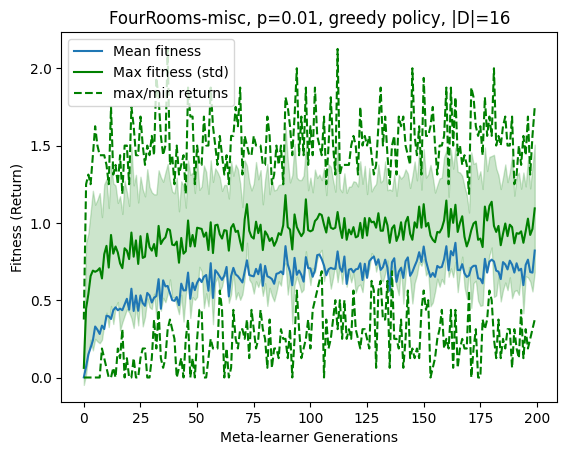

ParameterReshaper: 2 devices detected. Please make sure that the ES population size divides evenly across the number of devices to pmap/parallelize over.
ParameterReshaper: 64 parameters detected for optimization.


/private/home/alupu/.conda/envs/exp-env/lib/python3.9/site-packages/jax/_src/numpy/array_methods.py:795: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)


Gen: 0, Fitness: 0.00 +/- 0.01, Best: 0.07, BC loss: 0.51 +/- 0.19, BC acc: 0.78 +/- 0.11, Lap time: 4.6s
Gen: 20, Fitness: 0.44 +/- 0.13, Best: 0.93, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 26.8s
Gen: 40, Fitness: 0.48 +/- 0.14, Best: 1.01, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 26.4s
Gen: 60, Fitness: 0.45 +/- 0.11, Best: 1.01, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 26.4s
Gen: 80, Fitness: 0.38 +/- 0.11, Best: 1.01, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 26.4s
Gen: 100, Fitness: 0.54 +/- 0.10, Best: 1.10, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 27.2s
Gen: 120, Fitness: 0.49 +/- 0.09, Best: 1.10, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 27.1s
Gen: 140, Fitness: 0.63 +/- 0.10, Best: 1.10, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 26.7s
Gen: 160, Fitness: 0.67 +/- 0.11, Best: 1.10, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 26.3s
Gen: 180, Fitness: 0.62 +/

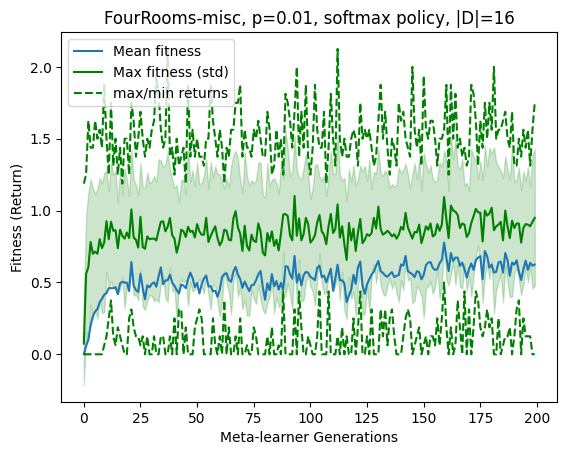

ParameterReshaper: 2 devices detected. Please make sure that the ES population size divides evenly across the number of devices to pmap/parallelize over.
ParameterReshaper: 64 parameters detected for optimization.
Gen: 0, Fitness: 0.03 +/- 0.12, Best: 1.58, BC loss: 0.51 +/- 0.19, BC acc: 0.78 +/- 0.11, Lap time: 4.3s
Gen: 20, Fitness: 3.20 +/- 0.54, Best: 5.00, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 25.9s
Gen: 40, Fitness: 3.63 +/- 0.48, Best: 5.19, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 25.8s
Gen: 60, Fitness: 3.95 +/- 0.33, Best: 5.28, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 25.9s
Gen: 80, Fitness: 4.34 +/- 0.35, Best: 5.54, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 25.9s
Gen: 100, Fitness: 4.79 +/- 0.67, Best: 7.03, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 26.0s
Gen: 120, Fitness: 5.10 +/- 0.74, Best: 8.57, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 26.0s
Gen: 140, Fitness: 5.55 +/- 0.

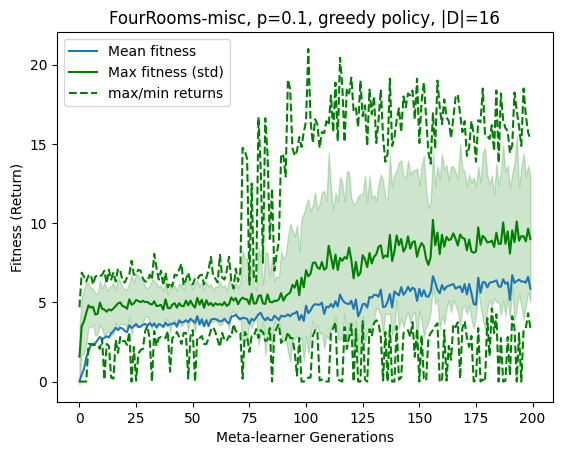

ParameterReshaper: 2 devices detected. Please make sure that the ES population size divides evenly across the number of devices to pmap/parallelize over.
ParameterReshaper: 64 parameters detected for optimization.
Gen: 0, Fitness: 0.03 +/- 0.12, Best: 1.57, BC loss: 0.51 +/- 0.19, BC acc: 0.78 +/- 0.11, Lap time: 4.7s
Gen: 20, Fitness: 3.43 +/- 0.69, Best: 5.35, BC loss: 0.00 +/- 0.01, BC acc: 1.00 +/- 0.00, Lap time: 26.8s
Gen: 40, Fitness: 4.08 +/- 0.58, Best: 6.04, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 27.4s
Gen: 60, Fitness: 4.68 +/- 0.84, Best: 8.19, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 27.5s
Gen: 80, Fitness: 5.84 +/- 1.07, Best: 9.18, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 27.5s
Gen: 100, Fitness: 6.73 +/- 1.12, Best: 11.04, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 27.5s
Gen: 120, Fitness: 8.00 +/- 1.36, Best: 13.12, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 27.5s
Gen: 140, Fitness: 8.07 +/- 

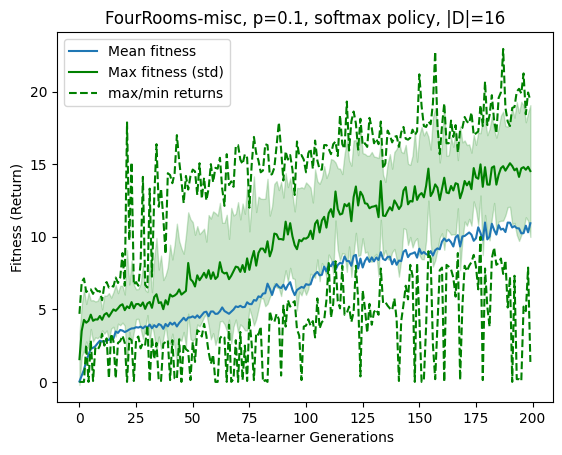

ParameterReshaper: 2 devices detected. Please make sure that the ES population size divides evenly across the number of devices to pmap/parallelize over.
ParameterReshaper: 64 parameters detected for optimization.
Gen: 0, Fitness: 0.06 +/- 0.20, Best: 2.48, BC loss: 0.51 +/- 0.19, BC acc: 0.78 +/- 0.11, Lap time: 4.3s
Gen: 20, Fitness: 5.05 +/- 0.81, Best: 7.25, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 27.0s
Gen: 40, Fitness: 6.43 +/- 0.59, Best: 7.66, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 26.9s
Gen: 60, Fitness: 6.28 +/- 0.48, Best: 7.84, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 26.2s
Gen: 80, Fitness: 6.09 +/- 0.70, Best: 8.06, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 26.1s
Gen: 100, Fitness: 6.44 +/- 0.43, Best: 8.19, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 27.0s
Gen: 120, Fitness: 7.02 +/- 0.46, Best: 8.35, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 26.4s
Gen: 140, Fitness: 6.66 +/- 0.

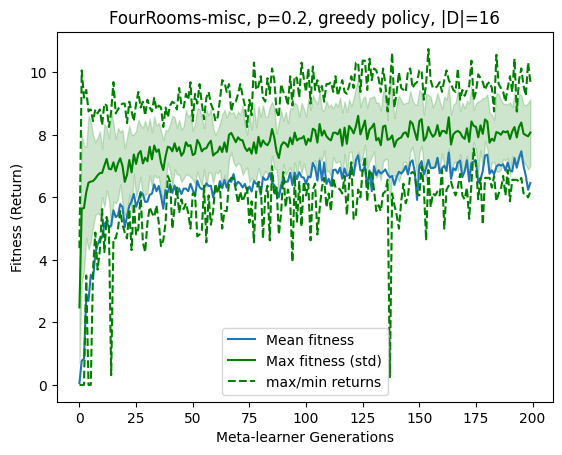

ParameterReshaper: 2 devices detected. Please make sure that the ES population size divides evenly across the number of devices to pmap/parallelize over.
ParameterReshaper: 64 parameters detected for optimization.


/private/home/alupu/.conda/envs/exp-env/lib/python3.9/site-packages/jax/_src/numpy/array_methods.py:795: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)


Gen: 0, Fitness: 0.06 +/- 0.20, Best: 2.48, BC loss: 0.51 +/- 0.19, BC acc: 0.78 +/- 0.11, Lap time: 5.0s
Gen: 20, Fitness: 5.48 +/- 0.56, Best: 7.18, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 27.4s
Gen: 40, Fitness: 6.45 +/- 0.51, Best: 7.73, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 27.2s
Gen: 60, Fitness: 6.10 +/- 0.51, Best: 7.73, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 26.4s
Gen: 80, Fitness: 6.52 +/- 0.49, Best: 7.92, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 26.4s
Gen: 100, Fitness: 6.17 +/- 0.47, Best: 7.92, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 27.1s
Gen: 120, Fitness: 7.07 +/- 0.50, Best: 8.09, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 27.2s
Gen: 140, Fitness: 6.91 +/- 0.51, Best: 8.33, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 26.5s
Gen: 160, Fitness: 7.02 +/- 0.45, Best: 8.33, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 26.2s
Gen: 180, Fitness: 6.96 +/

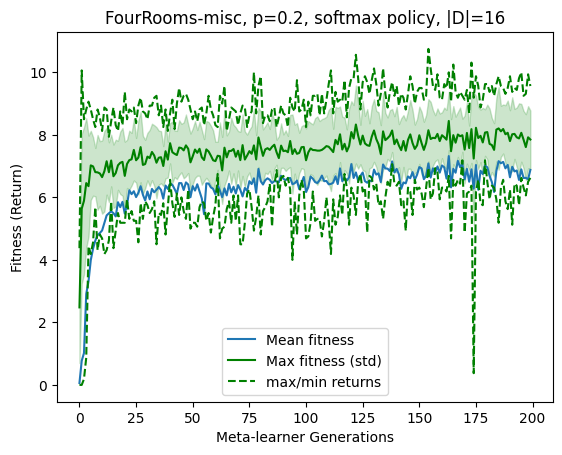

In [7]:
data = {}

for pts_per_action in [2,4]:
    print()
    print("DATASET SIZE : n_actions x ", pts_per_action)
    print()
    data[pts_per_action] = {}
    for fail_prob in [0, 0.01, 0.1, 0.2]:
        for greedy in [True, False]:
            
            config, es_config, n_actions, params, param_reshaper = get_configs_params(
                fail_prob = fail_prob, 
                datapoints_per_action = pts_per_action, 
                greedy_act = greedy,
                n_generations = 200
            )
            train_and_eval, strategy, state, es_params, rng = initialize_es(config, es_config, param_reshaper, n_actions)
            out, fitness, log, state = run_es(config, train_and_eval, es_config, strategy, state, param_reshaper, es_params, rng)
            
            act = "greedy" if config["GREEDY_ACT"] else "softmax"
            data[pts_per_action][f"p{fail_prob}_{act}"] = log
            
            plot_fitness(log, config, es_config)

In [8]:
import pickle as pkl

f = open("fourrooms_data.pkl", "wb")
pkl.dump(data, f)


DATASET SIZE : n_actions x  4

ParameterReshaper: 2 devices detected. Please make sure that the ES population size divides evenly across the number of devices to pmap/parallelize over.
ParameterReshaper: 64 parameters detected for optimization.
Gen: 0, Fitness: 0.00 +/- 0.00, Best: 0.00, BC loss: 0.51 +/- 0.19, BC acc: 0.78 +/- 0.11, Lap time: 4.2s
Gen: 20, Fitness: 0.00 +/- 0.10, Best: 2.25, BC loss: 0.52 +/- 0.19, BC acc: 0.78 +/- 0.12, Lap time: 25.8s
Gen: 40, Fitness: 0.95 +/- 1.72, Best: 13.50, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 25.9s
Gen: 60, Fitness: 2.06 +/- 2.30, Best: 15.75, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 25.9s
Gen: 80, Fitness: 3.75 +/- 2.83, Best: 15.75, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 25.9s
Gen: 100, Fitness: 5.03 +/- 3.29, Best: 18.00, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 25.9s
Gen: 120, Fitness: 5.19 +/- 3.88, Best: 22.50, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time:

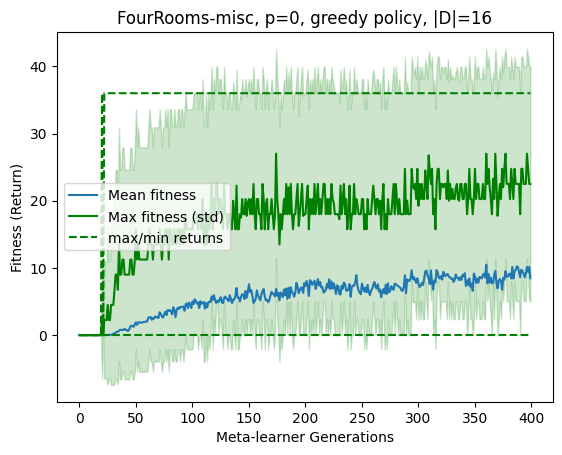

ParameterReshaper: 2 devices detected. Please make sure that the ES population size divides evenly across the number of devices to pmap/parallelize over.
ParameterReshaper: 64 parameters detected for optimization.


/private/home/alupu/.conda/envs/exp-env/lib/python3.9/site-packages/jax/_src/numpy/array_methods.py:795: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)


Gen: 0, Fitness: 0.00 +/- 0.00, Best: 0.00, BC loss: 0.51 +/- 0.19, BC acc: 0.78 +/- 0.11, Lap time: 4.5s
Gen: 20, Fitness: 0.02 +/- 0.32, Best: 6.24, BC loss: 0.07 +/- 0.08, BC acc: 0.98 +/- 0.04, Lap time: 26.4s
Gen: 40, Fitness: 0.73 +/- 1.45, Best: 11.02, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 26.2s
Gen: 60, Fitness: 2.05 +/- 2.47, Best: 13.36, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 26.3s
Gen: 80, Fitness: 3.55 +/- 2.90, Best: 15.75, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 26.3s
Gen: 100, Fitness: 5.15 +/- 3.61, Best: 20.25, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 26.3s
Gen: 120, Fitness: 7.07 +/- 4.09, Best: 22.50, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 26.2s
Gen: 140, Fitness: 8.32 +/- 4.36, Best: 27.00, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 26.1s
Gen: 160, Fitness: 12.03 +/- 4.85, Best: 29.53, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 26.2s
Gen: 180, Fitness:

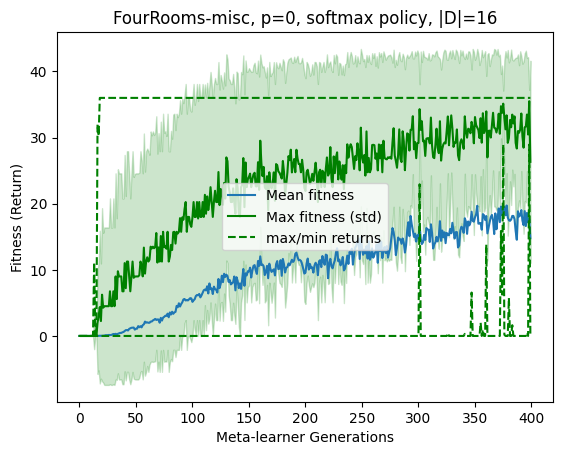

ParameterReshaper: 2 devices detected. Please make sure that the ES population size divides evenly across the number of devices to pmap/parallelize over.
ParameterReshaper: 64 parameters detected for optimization.
Gen: 0, Fitness: 0.00 +/- 0.01, Best: 0.06, BC loss: 0.51 +/- 0.19, BC acc: 0.78 +/- 0.11, Lap time: 4.8s
Gen: 20, Fitness: 0.44 +/- 0.10, Best: 0.92, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 26.0s
Gen: 40, Fitness: 0.50 +/- 0.16, Best: 0.98, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 26.5s
Gen: 60, Fitness: 0.65 +/- 0.11, Best: 1.02, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 26.4s
Gen: 80, Fitness: 0.72 +/- 0.11, Best: 1.12, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 26.4s
Gen: 100, Fitness: 0.71 +/- 0.11, Best: 1.18, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 26.5s
Gen: 120, Fitness: 0.70 +/- 0.09, Best: 1.18, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 26.5s
Gen: 140, Fitness: 0.71 +/- 0.

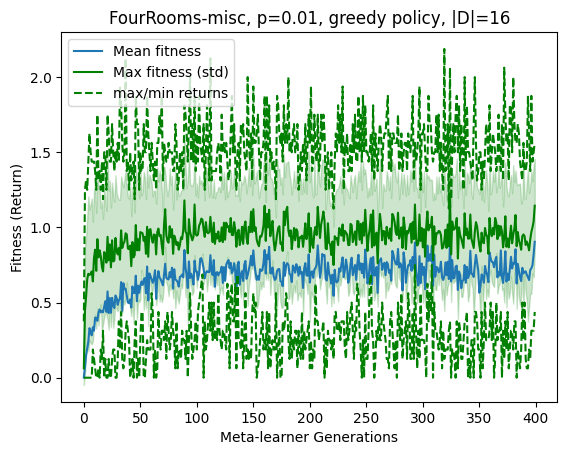

ParameterReshaper: 2 devices detected. Please make sure that the ES population size divides evenly across the number of devices to pmap/parallelize over.
ParameterReshaper: 64 parameters detected for optimization.


/private/home/alupu/.conda/envs/exp-env/lib/python3.9/site-packages/jax/_src/numpy/array_methods.py:795: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)


Gen: 0, Fitness: 0.00 +/- 0.01, Best: 0.07, BC loss: 0.51 +/- 0.19, BC acc: 0.78 +/- 0.11, Lap time: 4.5s
Gen: 20, Fitness: 0.44 +/- 0.13, Best: 0.93, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 26.4s
Gen: 40, Fitness: 0.48 +/- 0.14, Best: 1.01, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 26.4s
Gen: 60, Fitness: 0.45 +/- 0.11, Best: 1.01, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 26.4s
Gen: 80, Fitness: 0.38 +/- 0.11, Best: 1.01, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 26.4s
Gen: 100, Fitness: 0.54 +/- 0.10, Best: 1.10, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 26.4s
Gen: 120, Fitness: 0.49 +/- 0.09, Best: 1.10, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 26.4s
Gen: 140, Fitness: 0.63 +/- 0.10, Best: 1.10, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 26.5s
Gen: 160, Fitness: 0.67 +/- 0.11, Best: 1.10, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 26.4s
Gen: 180, Fitness: 0.62 +/

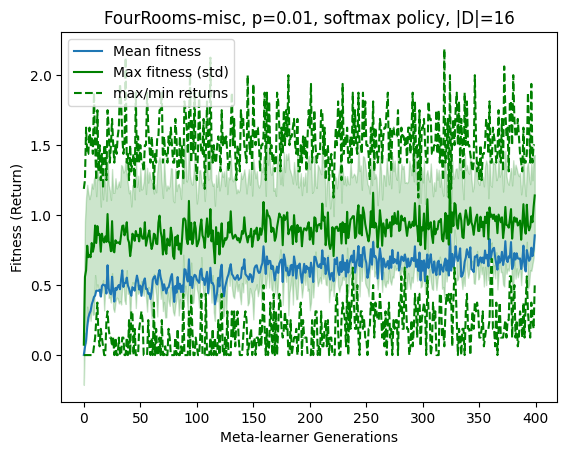

ParameterReshaper: 2 devices detected. Please make sure that the ES population size divides evenly across the number of devices to pmap/parallelize over.
ParameterReshaper: 64 parameters detected for optimization.
Gen: 0, Fitness: 0.03 +/- 0.12, Best: 1.58, BC loss: 0.51 +/- 0.19, BC acc: 0.78 +/- 0.11, Lap time: 4.3s
Gen: 20, Fitness: 3.20 +/- 0.54, Best: 5.00, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 27.4s
Gen: 40, Fitness: 3.63 +/- 0.48, Best: 5.19, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 27.4s
Gen: 60, Fitness: 3.95 +/- 0.33, Best: 5.28, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 27.6s
Gen: 80, Fitness: 4.34 +/- 0.35, Best: 5.54, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 27.3s
Gen: 100, Fitness: 4.79 +/- 0.67, Best: 7.03, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 26.7s
Gen: 120, Fitness: 5.10 +/- 0.74, Best: 8.57, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 26.7s
Gen: 140, Fitness: 5.55 +/- 0.

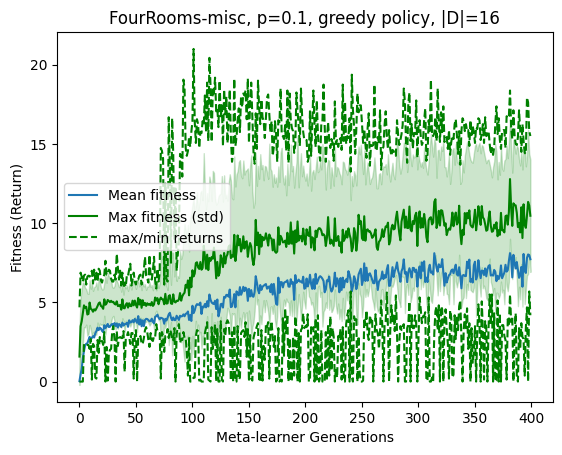

ParameterReshaper: 2 devices detected. Please make sure that the ES population size divides evenly across the number of devices to pmap/parallelize over.
ParameterReshaper: 64 parameters detected for optimization.


/private/home/alupu/.conda/envs/exp-env/lib/python3.9/site-packages/jax/_src/numpy/array_methods.py:795: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)


Gen: 0, Fitness: 0.03 +/- 0.12, Best: 1.57, BC loss: 0.51 +/- 0.19, BC acc: 0.78 +/- 0.11, Lap time: 5.0s
Gen: 20, Fitness: 3.43 +/- 0.69, Best: 5.35, BC loss: 0.00 +/- 0.01, BC acc: 1.00 +/- 0.00, Lap time: 26.6s
Gen: 40, Fitness: 4.08 +/- 0.58, Best: 6.04, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 25.8s
Gen: 60, Fitness: 4.68 +/- 0.84, Best: 8.19, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 26.1s
Gen: 80, Fitness: 5.84 +/- 1.07, Best: 9.18, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 26.2s
Gen: 100, Fitness: 6.73 +/- 1.12, Best: 11.04, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 26.3s
Gen: 120, Fitness: 8.00 +/- 1.36, Best: 13.12, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 26.3s
Gen: 140, Fitness: 8.07 +/- 1.53, Best: 13.83, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 26.2s
Gen: 160, Fitness: 9.67 +/- 1.37, Best: 14.69, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 26.2s
Gen: 180, Fitness: 9.8

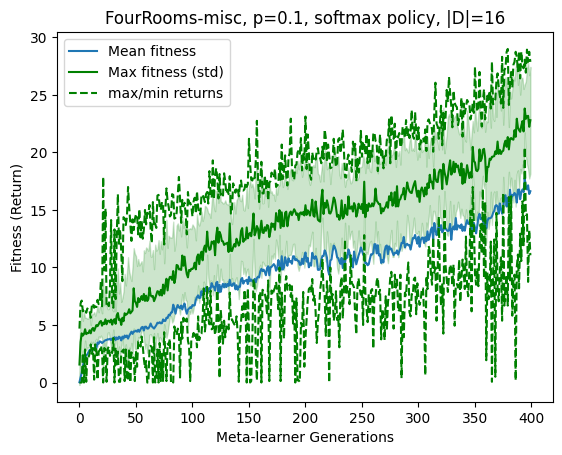

ParameterReshaper: 2 devices detected. Please make sure that the ES population size divides evenly across the number of devices to pmap/parallelize over.
ParameterReshaper: 64 parameters detected for optimization.
Gen: 0, Fitness: 0.06 +/- 0.20, Best: 2.48, BC loss: 0.51 +/- 0.19, BC acc: 0.78 +/- 0.11, Lap time: 4.2s
Gen: 20, Fitness: 5.05 +/- 0.81, Best: 7.25, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 26.3s
Gen: 40, Fitness: 6.43 +/- 0.59, Best: 7.66, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 25.7s
Gen: 60, Fitness: 6.28 +/- 0.48, Best: 7.84, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 25.8s
Gen: 80, Fitness: 6.09 +/- 0.70, Best: 8.06, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 26.4s
Gen: 100, Fitness: 6.44 +/- 0.43, Best: 8.19, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 25.7s
Gen: 120, Fitness: 7.02 +/- 0.46, Best: 8.35, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 25.9s
Gen: 140, Fitness: 6.66 +/- 0.

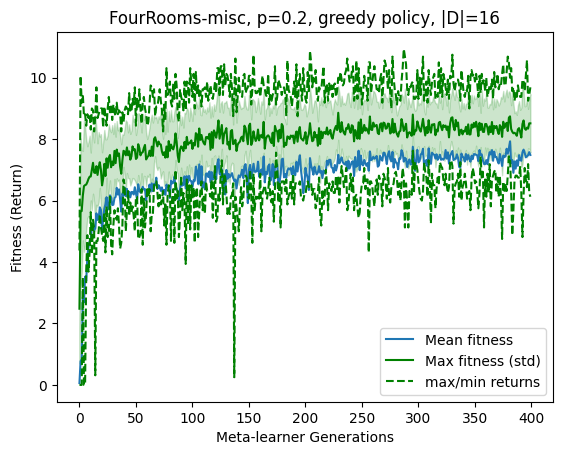

ParameterReshaper: 2 devices detected. Please make sure that the ES population size divides evenly across the number of devices to pmap/parallelize over.
ParameterReshaper: 64 parameters detected for optimization.


/private/home/alupu/.conda/envs/exp-env/lib/python3.9/site-packages/jax/_src/numpy/array_methods.py:795: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)


Gen: 0, Fitness: 0.06 +/- 0.20, Best: 2.48, BC loss: 0.51 +/- 0.19, BC acc: 0.78 +/- 0.11, Lap time: 4.5s
Gen: 20, Fitness: 5.48 +/- 0.56, Best: 7.18, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 27.0s
Gen: 40, Fitness: 6.45 +/- 0.51, Best: 7.73, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 26.2s
Gen: 60, Fitness: 6.10 +/- 0.51, Best: 7.73, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 26.1s
Gen: 80, Fitness: 6.52 +/- 0.49, Best: 7.92, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 26.1s
Gen: 100, Fitness: 6.17 +/- 0.47, Best: 7.92, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 26.1s
Gen: 120, Fitness: 7.07 +/- 0.50, Best: 8.09, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 26.2s
Gen: 140, Fitness: 6.91 +/- 0.51, Best: 8.33, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 26.1s
Gen: 160, Fitness: 7.02 +/- 0.45, Best: 8.33, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 26.0s
Gen: 180, Fitness: 6.96 +/

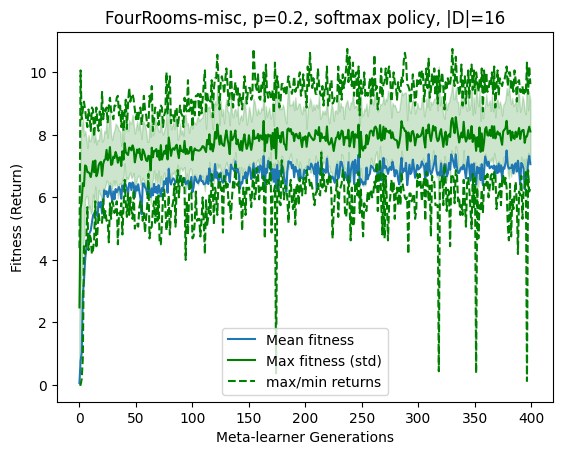

In [9]:
datalonger = {}

for pts_per_action in [4]:
    print()
    print("DATASET SIZE : n_actions x ", pts_per_action)
    print()
    datalonger[pts_per_action] = {}
    for fail_prob in [0, 0.01, 0.1, 0.2]:
        for greedy in [True, False]:
            
            config, es_config, n_actions, params, param_reshaper = get_configs_params(
                fail_prob = fail_prob, 
                datapoints_per_action = pts_per_action, 
                greedy_act = greedy,
                n_generations = 400
            )
            train_and_eval, strategy, state, es_params, rng = initialize_es(config, es_config, param_reshaper, n_actions)
            out, fitness, log, state = run_es(config, train_and_eval, es_config, strategy, state, param_reshaper, es_params, rng)
            
            act = "greedy" if config["GREEDY_ACT"] else "softmax"
            datalonger[pts_per_action][f"p{fail_prob}_{act}"] = log
            
            plot_fitness(log, config, es_config)

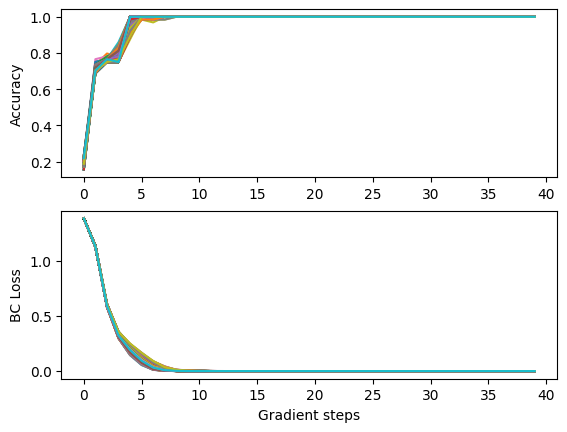

In [19]:
def reshape(arr):
    """Removes extra dim due to pmap"""
    dims = arr.shape
    arr = arr.reshape(-1,dims[-2],dims[-1])
    return arr

fig, ax = plt.subplots(2, 1)
for i in range(es_config["popsize"]):
    acc = reshape(out["metrics"]["bc_accuracy"])[i].mean(axis=0)
    ax[0].plot(acc)
    ax[0].set_ylabel("Accuracy")
    

    loss = reshape(out["metrics"]["bc_loss"])[i].mean(axis=0)
    ax[1].plot(loss)
    ax[1].set_ylabel("BC Loss")
    ax[1].set_xlabel("Gradient steps")

## Double check policy return

In [20]:
P = es_config["popsize"]
final_datasets_reshaped = param_reshaper.reshape(datasets)

best = fitness.argmax()

if len(jax.devices()) > 1:
    best_idx = (best // (P//2), best % (P//2))
else:
    best_idx = (best % (P//2))

final_gen_dataset = final_datasets_reshaped[best_idx]
# final_dataset = final_gen_dataset
final_dataset = state.best_member

final_dataset = final_dataset.reshape(final_gen_dataset.shape)

print("Final dataset:")
print(final_dataset)

Final dataset:
[[-0.3077113  -0.06033682 -0.23897025  0.18844752]
 [-0.21433476 -0.3095708   0.3604658   0.21940136]
 [ 0.04107637  0.3436863   0.15115716 -0.2385284 ]
 [-0.2700981   0.22679488 -0.35999706 -0.12627596]]


In [21]:
best_returns = returns[best_idx]
best_dones = dones[best_idx]

# want returns on episodes on which we finish:
import numpy as np
cand_ret = np.zeros((16,16))

for i in range(16):
    for j in range(16):
        if best_dones[i,:,j].sum() > 0:
            cand_ret[i,j] = best_returns[i,:,j][best_dones[i,:,j]].sum()
            
cand_ret

print("Network returns (mean across envs):")
print(cand_ret.mean(1))

print("Envs returns (mean across networks):")
print(cand_ret.mean(0))


Network returns (mean across envs):
[1.4375 0.875  0.75   0.75   2.0625 1.5    1.6875 1.5625 1.8125 2.5
 1.125  2.125  1.8125 1.75   1.9375 1.5625]
Envs returns (mean across networks):
[1.3125 1.8125 2.625  1.375  1.1875 1.6875 1.3125 1.625  1.     1.625
 0.875  1.4375 2.     1.5    2.     1.875 ]


In [22]:
train_state = out["runner_state"][0]
# Note: if multiple rollouts / candidate, pick first rollout
if len(jax.devices()) > 1:
    f = lambda x : x[best_idx[0], best_idx[1], 0]
else:
    f = lambda x : x[best_idx, 0]
best_params = jax.tree_util.tree_map(f, train_state.params)

best_ret = returns[best_idx]
best_dones = dones[best_idx]

best_mean_ret  = (best_ret*best_dones).sum(axis=(1,2)) / config["NUM_ENVS"]
print("Best mean return per rollout \n", best_mean_ret)

Best mean return per rollout 
 [1.4375 0.875  0.75   0.75   2.0625 1.5    1.6875 1.5625 1.8125 2.5
 1.125  2.125  1.8125 1.75   1.9375 1.5625]


In [ ]:
test_returns = []

for i in tqdm(range(es_config["rollouts_per_candidate"])):
    g = lambda x : x[best_idx[0], best_idx[1], i]
    best_params = jax.tree_util.tree_map(g, train_state.params)

    env, env_params = gymnax.make(config["ENV_NAME"])
    env_params = env_params.replace(**config["ENV_PARAMS"])
    env = FlattenObservationWrapper(env)
    env = LogWrapper(env)

    n_actions = env.action_space(env_params).n

    rng = jax.random.PRNGKey(42)
    rng, reset_rng = jax.random.split(rng)
    obs, env_state = env.reset(reset_rng, env_params)

    rewards_per_ep = []
    ret = 0

    for t in range(256):
        rng, rng_act, rng_step = jax.random.split(rng, 3)

        pi = train_state.apply_fn(best_params, obs)
        action = pi.argmax(axis=-1)

        obs, env_state, reward, done, info = env.step(rng_step, env_state, action, env_params) 
        rewards_per_ep.append(reward)
        if done:
            ep_ret = jnp.array(rewards_per_ep).sum()
            rewards_per_ep = []
            ret += reward.item()
            
    test_returns.append(ret)

print("returns: ", test_returns)

In [ ]:
# SEE POLICY PLAY

# reg_env, env_params = gymnax.make(config["ENV_NAME"])
# env = FlattenObservationWrapper(env)

# env_params = env_params.replace(fail_prob=0)

# n_actions = env.action_space(env_params).n

# rng = jax.random.PRNGKey(42)
# rng, reset_rng = jax.random.split(rng)
# obs, env_state = env.reset(reset_rng, env_params)
# _, reg_env_state = reg_env.reset(reset_rng, env_params)
# img, ax = env.render(reg_env_state, env_params)

# rewards_per_ep = []

# for t in range(10):
#     rng, rng_act, rng_step = jax.random.split(rng, 3)
    
#     pi = train_state.apply_fn(best_params, obs)
#     action = pi.argmax(axis=-1)

#     obs, env_state, reward, done, info = env.step(rng_step, env_state, action, env_params)
#     _, reg_env_state, _, _, _ = reg_env.step(rng_step, reg_env_state, action, env_params)
    
#     img, ax = env.render(reg_env_state, env_params)
    
#     rewards_per_ep.append(reward)
#     if done:
#         ep_ret = jnp.array(rewards_per_ep).sum()
#         print("Ep return: ", ep_ret)
#         rewards_per_ep = []


[-0.3077113  -0.06033682 -0.23897025  0.18844752]
[-0.21433476 -0.3095708   0.3604658   0.21940136]
[ 0.04107637  0.3436863   0.15115716 -0.2385284 ]
[-0.2700981   0.22679488 -0.35999706 -0.12627596]


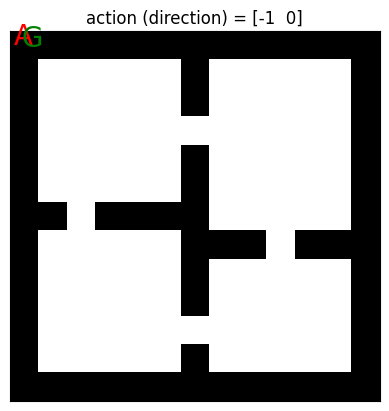

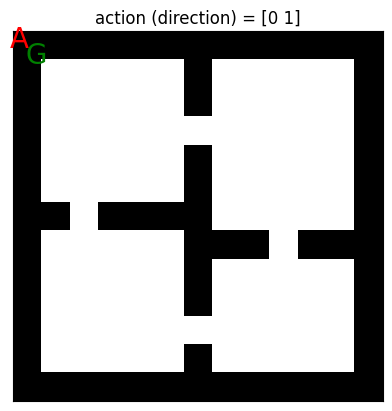

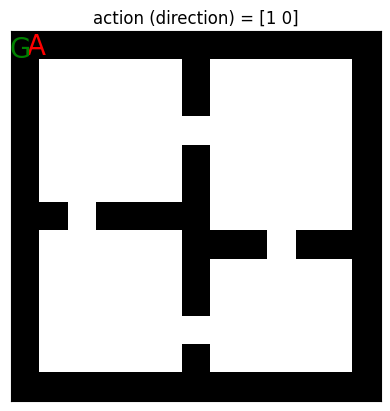

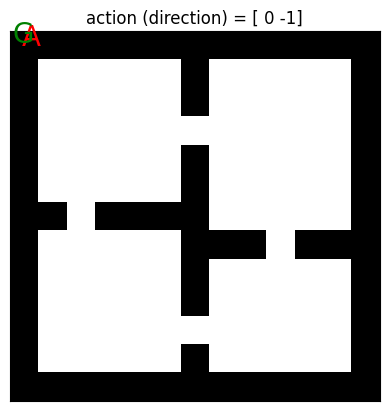

In [23]:
from policy_distillation.render import render_fourrooms as render_fn
# fig, ax = plt.subplots(1,n_actions, figsize=(12,8))

env_name = "FourRooms-misc"
env, env_params = gymnax.make(env_name)

rng_env = jax.random.PRNGKey(1)
obs, env_state = env.reset(rng_env)

for i, synth_obs in enumerate(final_dataset):
    
    synth_state = env_state.replace(pos=synth_obs[:2], goal=synth_obs[2:])
    img, ax = render_fn(synth_state, env_params)
    
    ax.set_title(f"action (direction) = {env.directions[i]}")
    
#     img.show()
    
#     ax[i].imshow(img, label="hello")
#     ax[i].set_title(f"action = {action_labels[i]}")
    
#     theta_dot1 = synth_state[-2].item()
#     theta_dot2 = synth_state[-1].item()
    
    print(synth_obs)
    
# #     ax[i].set_xticks([0, 600/2, 600], [-4.8, 0, 4.8])
#     ax[i].text(330, 70, f"dθ1={theta_dot1:.2f} \ndθ2={theta_dot2:.2f}", bbox=dict(fill=False, edgecolor='red', linewidth=2))

## TODO:

1. Investigate nan / fitness computation for CartPole
    - Division by zero if episodes not done


## Generalization

In [24]:
width_list = [2,4,8,16,32,64,128,256,512,1024]
fit_list = {
            "relu" : [],
            "tanh" : []
           }
for width in width_list:
    new_config = config.copy()
    new_config["WIDTH"] = width
    new_config["UPDATE_EPOCHS"] = 10
    num_envs = 20
    
    transfer_fitness ={
            "relu" : -1,
            "tanh" : -1
           }
    
    for activation in ["relu", "tanh"]:
        new_config["ACTIVATION"] = activation

        final_dataset # Given
        action_labels # Given

        new_train_fn = make_train(new_config)

        def new_BC_train(rng_input, dataset):
            out = new_train_fn(dataset, action_labels, rng_input)
            return out  # ["metrics"]['returned_episode_returns'].mean()

        vmapped_BC_train = jax.jit(jax.vmap(new_BC_train, in_axes=(0, None)))

        rng, rng_new = jax.random.split(rng)
        rng_batch = jax.random.split(rng_new, num_envs)

        out_new = vmapped_BC_train(rng_batch, final_dataset)

        returns = out_new["metrics"]["returned_episode_returns"]  # dim=(popsize, rollout_news, num_steps, num_envs)
        dones = out_new["metrics"]["returned_episode"]  # same dim, True for last steps, False otherwise
#         transfer_fitness[activation] = (returns * dones).sum(axis=(-1,-2)) / dones.sum(axis=(-1,-2)) 
        transfer_fitness[activation] = (returns * dones).sum(axis=(-1, -2)) / num_envs
        bc_loss = out_new['metrics']['bc_loss'][:,-1]

        fit_list[activation].append(transfer_fitness[activation])
    
    print(f"Width {width} : transfer_fitness (relu)={transfer_fitness['relu'].mean():.1f} +/- {transfer_fitness['relu'].std():.1f}, "
         + f"transfer_fitness (tanh)={transfer_fitness['tanh'].mean():.1f} +/- {transfer_fitness['tanh'].std():.1f}")
    

/private/home/alupu/.conda/envs/exp-env/lib/python3.9/site-packages/jax/_src/numpy/array_methods.py:795: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)


Width 2 : transfer_fitness (relu)=0.4 +/- 0.5, transfer_fitness (tanh)=0.6 +/- 0.6
Width 4 : transfer_fitness (relu)=0.3 +/- 0.5, transfer_fitness (tanh)=0.9 +/- 1.0
Width 8 : transfer_fitness (relu)=0.3 +/- 0.4, transfer_fitness (tanh)=0.4 +/- 0.9
Width 16 : transfer_fitness (relu)=0.6 +/- 0.8, transfer_fitness (tanh)=0.3 +/- 0.4
Width 32 : transfer_fitness (relu)=0.3 +/- 0.3, transfer_fitness (tanh)=0.5 +/- 0.5
Width 64 : transfer_fitness (relu)=0.7 +/- 0.4, transfer_fitness (tanh)=0.4 +/- 0.4
Width 128 : transfer_fitness (relu)=0.8 +/- 0.4, transfer_fitness (tanh)=0.5 +/- 0.5
Width 256 : transfer_fitness (relu)=1.1 +/- 0.5, transfer_fitness (tanh)=0.3 +/- 0.3
Width 512 : transfer_fitness (relu)=0.7 +/- 0.4, transfer_fitness (tanh)=0.2 +/- 0.3
Width 1024 : transfer_fitness (relu)=0.9 +/- 0.5, transfer_fitness (tanh)=0.4 +/- 0.6


In [ ]:
for activation, act_fit_list in fit_list.items():
    plt.scatter(width_list, [x.mean() for x in act_fit_list], label=activation)

    means = jnp.array([x.mean() for x in act_fit_list])
    stds = jnp.array([x.std() for x in act_fit_list])

    plt.errorbar(width_list, means, stds, alpha=0.5)
plt.ylabel("Fitness")
plt.xlabel("Network width (log scale)")
plt.xscale("log")
plt.xticks(width_list, width_list)
plt.title(f"Dataset transfer (original: {config['ACTIVATION']}{config['WIDTH']} )")
plt.legend()
plt.show()

In [ ]:
fit_list["relu"][5].std()